<a href="https://colab.research.google.com/github/davidepelliciari/statistics/blob/master/Importance_sampling_integration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uso dell'importance sampling nel calcolo di un integrale definito

Di seguito vogliamo stimare il seguente integrale:

 $I = \displaystyle \int_0^1 e^{-x^2} dx$

 Eseguiamo la stima prima attraverso un sample uniforme $U(0,1)$ e poi applicando l'importance sampling. In pratica viene usata una distribuzione diversa dall'integranda per il sampling per ottenere un'errore più piccolo sul risultato. Per una generica funzione $f(x)$, si può scrivere:

 $I = \displaystyle \int_a^b f(x)dx = E_U[f(x)]$

 Lo stimatore per questo integrale è:   $ \hat{I} = \frac{b-a}{N} \displaystyle \sum_{i=1}^N f(x_i)$.

 Si può dimostrare facilmente che $E[\hat{I}]$ è pari all'integrale. L'integrale $I$ può essere riscritto come:

 $ I = \displaystyle \int_a^b \frac{f(x)}{p(x)} p(x) dx = E_p\Big[\frac{f(x)}{p(x)}\Big]$

 Dunque scegliendo una pdf $p(x)$, dalla quale il sample è estratto, è possibile ottenere una stima dell'integrale. Scegliendo una buona pdf è possibile ridurre la varianza sulla stima dell'integrale.

# 1. Implementazione in uno script python: dichiarazioni

Importiamo qualche buona libreria che non fa mai male:

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.optimize
import math

E dichiariamo le variabili principali e le costanti matematiche di cui faremo uso:

In [0]:
# Dichiarazioni
a = 0
b = 1
B = 0.5
e = math.e
Num = 10000   #Numero di samples da generare

truth = 0.7468241328    #valore vero dell'integrale, calcolato con wolfram Alpha

A questo punto definiamo le funzioni necessarie per calcolare l'integrale. Definiamo la funzione integranda, la pdf $p(x)$ da cui estrarre il sample e una funzione che restituisca il valore dello stimatore $\hat{I}$. Abbiamo scelto di usare la seguente pdf per l'estrazione del sample:

$p(x) = A e^{-Bx}$

Dove i valori di $A$ e $B$ sono determinati dalla condizione di normalizzazione:

$\displaystyle \int_a^b p(x) dx = 1$

Dal momento che si tratta di una distribuzione di probabilità. In seguito faremo variare B nel range $[0.5,5]$, dunque $A$ sarà fissato, per ogni valore di B, al valore:

$A = \displaystyle \frac{B}{1-e^{-B}}$

Ottenuto sempre dalla condizione di normalizzazione.

In [0]:
# ----------- Dichiarazione funzioni

def fun(x):     #integranda
    return e**(-x**2)



def P(x, B):       #pdf candidata per l'importance sampling
    if(B==0):
        A = 1
    else:
        A = B/(1-e**(-B))

    return A*e**(-B*x)


def integral(x,N,B):      #formula per lo stimatore di I secondo importance sampling
    sum = 0
    for i in range (0,N):
        sum = sum + (fun(x[i])/P(x[i],B))
    return (1/N)*sum


Definiamo poi una funzione molto importante, la funzione randdist. Questa funzione permette di ottenere un sample di valori da una distribuzione di probabilità a scelta, nel nostro caso quest'ultima sarà proprio la $p(x)$.



In [0]:
def randdist(x, pdf, nvals):    #genera un sample distribuito secondo una pdf a scelta (P(x))
    """Produce nvals random samples from pdf(x), assuming constant spacing in x."""

    # get cumulative distribution from 0 to 1
    cumpdf = np.cumsum(pdf)
    cumpdf *= 1/cumpdf[-1]

    # input random values
    randv = np.random.uniform(size=nvals)

    # find where random values would go
    idx1 = np.searchsorted(cumpdf, randv)
    # get previous value, avoiding division by zero below
    idx0 = np.where(idx1==0, 0, idx1-1)
    idx1[idx0==0] = 1

    # do linear interpolation in x
    frac1 = (randv - cumpdf[idx0]) / (cumpdf[idx1] - cumpdf[idx0])
    randdist = x[idx0]*(1-frac1) + x[idx1]*frac1

    return randdist

# 2. Distribuzione dei risultati: confronto tra p(x) e la dist. uniforme

Siamo pronti a calcolare la stima del nostro integrale seguendo due distribuzioni differenti per l'estrazione dei sample:

1. Distribuzione uniforme $U(0,1)$, implementata dalla funzione del pacchetto numpy np.random.rand();

2. Distribuzione $p(x) = p(x,B=1) = Ae^{-x}$.

Ora vogliamo generare tante volte il sample di valori x e vedere come si distribuiscono i risultati per le due distribuzioni.

Per fare questo impostiamo il numero di sample da generare (N_sim), ricordando che ogni sample è un insieme di valori x distribuiti secondo una determianta distribuzione di probabilità. Ogni sample sarà quindi simile all'altro ma comunque diverso, dato che i valori vengono scelti randomicamente seguendo la stessa pdf. Inoltre inizializziamo a zero gli array che conterranno i 500 valori dell'integrale calcolato: per la pdf a scelta $p(x)$ (ris), per la distribuzione uniforme $U(0,1)$ (ris_un), e un array che conterrà i numeri delle varie estrazioni (cioè 0,1,2,3,4,..,499).

In [0]:
N_sim = 500
x = np.linspace(a,b,Num)
ris = np.zeros(N_sim)
ris_un = np.zeros(N_sim)
sim_number = np.zeros(N_sim)

Con un ciclo for possiamo fare le estrazioni e salvare ogni risultato del cilo nell'array ris e ris_un:

In [0]:
for i in range(0,N_sim):
    x_vals = randdist(x, P(x,1), Num)
    x_unif = np.random.rand(Num)
    ris[i] = integral(x_vals,Num,1)
    ris_un[i] = integral(x_unif, Num, 0)
    sim_number[i] = i

Ora possiamo visualizzare l'istogramma della distribuzione dei risultati:

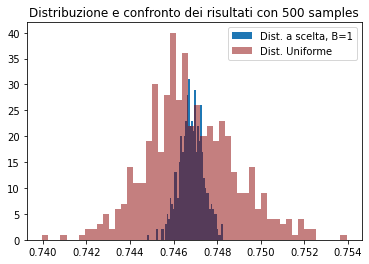

In [10]:
plt.title("Distribuzione e confronto dei risultati con " + str(N_sim) +" samples")
plt.hist(ris,50, label='Dist. a scelta, B=1')
plt.hist(ris_un,50, color='darkred', label='Dist. Uniforme', alpha=0.5)
plt.legend()
plt.show()

Come si può notare molto facilmente, le due distribuzioni appaiono molto diverse tra loro. In particolare la distribuzione dei risultati ottenuta estraendo i sample dalla $p(x) = Ae^{-x}$ ha una deviazione standard dal valore medio, praticamente coincidente con il valore vero, molto minore rispetto all'altra.

Si possono visualizzare i risultati anche in un normale plot:

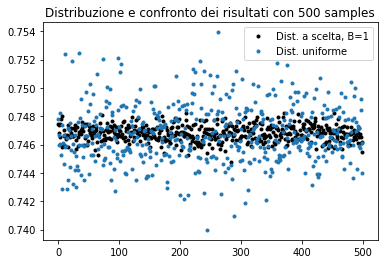

In [11]:
plt.title("Distribuzione e confronto dei risultati con " + str(N_sim) +" samples")
plt.plot(sim_number,ris,marker='.', linestyle='',color='k',label="Dist. a scelta, B=1")
plt.plot(sim_number,ris_un, marker='.', linestyle='', label="Dist. uniforme")
plt.legend()
plt.show()

In questo caso i risultati sono mostrati sample dopo sample. Anche qui si nota la maggior dispersione dei risultati ottenuti con distribuzione uniforme.

# 3. Quale curva permette di ottenere un risultato migliore?

Ora che abbiamo capito che l'importance sampling permette di ottenere valori più accurati per il nostro integrale ci chiediamo quale sia la distribuzione di probabilità che minimizzi l'errore rispetto al risultato vero. Abbiamo detto che la funzione attraverso cui estraiamo i nostri valori x è nella forma:

$\displaystyle p_B(x) = A e^{-Bx}$

Facendo dunque variare $B$ nel range $[0.5,5]$ ci chiediamo quale sia la curva che permetta di ottenere il risultato migliore.

Per fare ciò implementiamo un ciclo for che incrementi il valore di $B$ partendo da $0.5$ arrivando fino a $5$ e che a ogni ciclo richiami l'estrazione del sample tramite $p(x)$ e con questa calcoli l'integrale. In codice:

In [0]:
x_unif = np.random.rand(Num)

bins = 50   #quanti valori per B?

results = np.zeros(bins)
Disc = np.zeros(bins)
Bs = np.zeros(bins)

B = 0

for i in range(0,bins):
    B += 5/bins
    Bs[i] = B   #Array che salva i valori di B
    randdist_vals = randdist(x,P(x,B),Num)
    int = integral(randdist_vals, Num,B)
    results[i] = int
    Disc[i] = np.abs((int - truth)/truth)

Vogliamo dunque fare un confronto tra le varie curve $p_B(x)$, e per completezza mostriamo il risultato del sample uniforme:

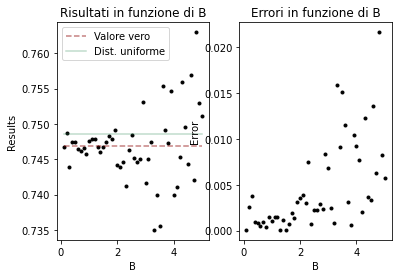

In [14]:
# Distribuzione dei risultati (integrali) in funzione del valore di B
plt.subplot(1,2,1)
plt.title("Risultati in funzione di B")
plt.plot(Bs,results, marker='.', linestyle='',color='k')
plt.plot(Bs,truth + Bs*0, color='darkred', linestyle='--', alpha=0.5, label="Valore vero")
plt.plot(Bs, integral(x_unif, Num, 0) + Bs*0, color='seagreen',alpha=0.3, label="Dist. uniforme")
plt.xlabel("B")
plt.ylabel("Results")
plt.legend()

plt.subplot(1,2,2)
plt.title("Errori in funzione di B")
plt.plot(Bs,Disc, marker='.', linestyle='',color='k')
plt.xlabel("B")
plt.ylabel("Error")
plt.show()

Come si può notare, man mano che $B$ aumenta, il valore dell'integrale calcolato si disperde sempre di più.

Infine implementiamo un ciclo for che permetta di trovare il minimo errore tra i risultati ottenuti:

In [0]:
# -------------- FIND THE MINIMUM ERROR

min = results[1]
val = 0

for i in range(2,bins):
    if(Disc[i] < min):
        min = Disc[i]
        val = i
    else:
        continue

In [16]:
print("!!! IMPORTANCE SAMPLING !!!")
print("\n")
print("Ho svolto un'analisi su quale fosse la migliore funzione da cui prendere il sample di valori.")
print("\n")
print("La funzione e' nella forma: A e^Bx. Facendo variare B da 0.5 a 5 in un range di 50 valori si ottiene:")
print("\n")
print("Valore migliore trovato per l'integrale: ", results[val], "\n")
print("Valore vero pari a: ", truth, "\n")
print("B: ", Bs[val], "\n")
print("con errore: ", Disc[val], "\n")

!!! IMPORTANCE SAMPLING !!!


Ho svolto un'analisi su quale fosse la migliore funzione da cui prendere il sample di valori.


La funzione e' nella forma: A e^Bx. Facendo variare B da 0.5 a 5 in un range di 50 valori si ottiene:


Valore migliore trovato per l'integrale:  0.7467677390869629 

Valore vero pari a:  0.7468241328 

B:  1.5000000000000002 

con errore:  7.551136949161702e-05 



Per avere un'idea grafica di quale curva corrisponde il valore di B trovato implementiamo il seguente codice:

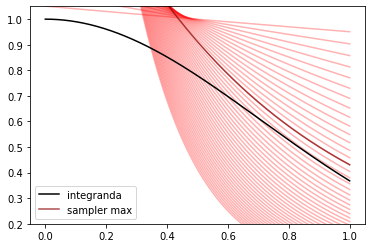

In [17]:
B = 0
for i in range(0,bins):
    B+=5/bins
    plt.plot(x,P(x,B),color='red',alpha=0.3)

plt.plot(x,fun(x),color='k', label="integranda")
plt.plot(x,P(x,Bs[val]), color='darkred', alpha=0.7, label='sampler max')
plt.ylim(0.2,1.05)
plt.legend()
plt.show()

In questo ultimo grafico si può vedere in nero la funzione di cui vogliamo conoscere l'integrale, in rosso le varie curve al variare di B e in rosso scuro la curva che minimizza l'errore nel calcolo dell'integrale.

# Disclaimer

Il valore di $B$ trovato non è un valore di cui possiamo fidarci in modo generale. Questo perchè il sample è comunque estratto in modo randomico e quindi cambia ogni volta che eseguiamo il codice. Dunque la distribuzione dei risultati in funzione di $B$ cambierà leggermente ed è possibile che quel valore di $B$ trovato cambi a sua volta.

Per avere un'idea di quale statisticamente sia la miglior curva è necessario ripetere il procedimento 2. con più valori di $B$ e confrontare le distribuzioni dei risultati. Tuttavia questo procedimento di calcolo, per essere reso più generale possibile, richiede una quantità di calcolo computazionale non indifferente e non lo presenteremo qui.